In [2]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


import statsmodels.formula.api as sm, statsmodels.stats.api as sms


from run_id import run_id

run_id = 662

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

In [3]:
tsums = topics.aggregate(
    ip_score=Sum('ipcc_score'),
    score=Sum('ipcc_time_score')
)
tsums

topics.update(
    ipcc_share=F('ipcc_score')/tsums['ip_score'],
    share=F('ipcc_time_score')/tsums['score']
)

100

In [76]:
def calculate_deviations(df):
    df['deviation'] = df['ipcc_share'] - df['share']
    df['abs_md'] = abs(df['deviation'])

    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    df['representation'] = df['ipcc_share'] / df['share']  
    
    df_disp = {'MD':md,'Rae':rae,'L-H':lh}
    return [df,df_disp]


In [24]:



df = pd.DataFrame.from_dict(
    list(topics.values(
        'title',
        'score',
        'ipcc_coverage',
        'share',
        'ipcc_score',
        'ipcc_share',
        'ipcc_time_score'
    ))
)

df, df_disp  = calculate_deviations(df)


df.sort_values('representation').head()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,score,share,title,deviation,abs_md,representation
50,0.029822,6.996709,0.000926,234.618406,668.346077,0.004727,"{adsorpt, adsorb, capac}",-0.003801,0.003801,0.195844
12,0.039887,10.607514,0.001404,265.938777,385.865575,0.005358,"{root, respir, fine}",-0.003955,0.003955,0.261946
79,0.040632,24.862808,0.003290,611.903042,1298.677539,0.012328,"{process, captur, reaction}",-0.009039,0.009039,0.266838
51,0.041303,10.294637,0.001362,249.246622,492.612029,0.005022,"{wast, landfil, compost}",-0.003660,0.003660,0.271245
19,0.044705,20.371524,0.002695,455.684960,683.251724,0.009181,"{sediment, deposit, eros}",-0.006486,0.006486,0.293588


In [63]:
df.sort_values('representation').tail()

,title,ipcc_score,ipcc_share,score,share,deviation,abs_md,representation
87,"{project, futur, rcp}",67.218808,0.019754,267.707619,0.009227,0.010527,0.010527,2.140936
31,"{scenario, futur, use}",70.462256,0.020707,279.218774,0.009623,0.011084,0.011084,2.151719
89,"{ozon, stratospher, tropospher}",41.779779,0.012278,155.243379,0.005351,0.006927,0.006927,2.294704
46,"{adapt, vulner, capac}",84.433234,0.024813,280.590171,0.009671,0.015142,0.015142,2.565751
50,"{aerosol, cloud, radiat}",63.876430,0.018772,206.515118,0.007118,0.011654,0.011654,2.637317


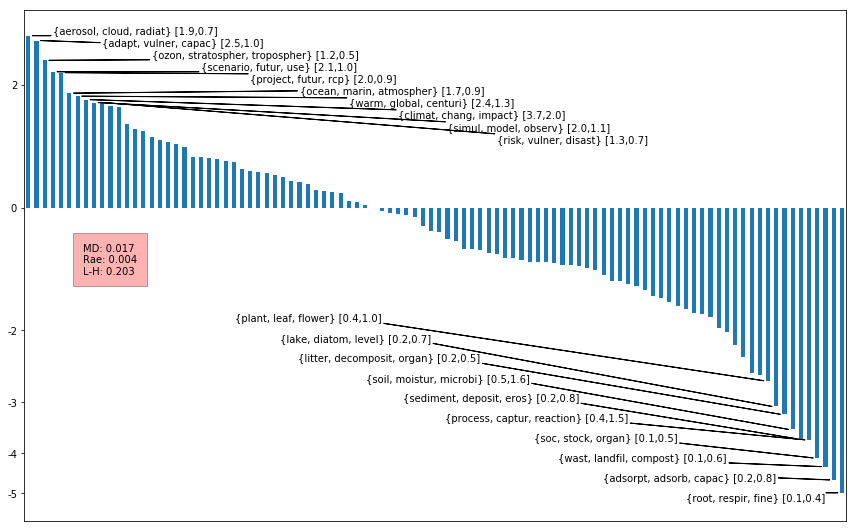

In [156]:

from matplotlib import ticker


plt.rcParams["figure.figsize"] = [12,7.5]

def plot_representation(df, ax, nts=5, xspace=3,yspace = 0.15, fmin=None, fmax=None):
    
    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    pdf = df.sort_values('representation',ascending=False).reset_index('title')

    pdf = pdf[pdf['share'] > 0.001]

    pdf['lrep'] = np.log(pdf['representation'])
    #pdf['lrep'] = pdf['representation']
    pdf.set_index('title')['lrep'].plot(kind="bar",ax=ax)

    i = 0

    rmax = pdf['lrep'].max()
    if fmax:
        rmax = fmax
    rmin = pdf['lrep'].min()
    if fmin:
        rmin = -fmin
    
    for index, row in pdf.head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(-0.5+i,row['lrep']),
            xytext=((xspace-3)*-1+i*xspace,rmax-rmax*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="left",
            va="bottom"
        )

    i = 0
    for index, row in pdf.sort_values('representation').head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(len(pdf)-0.5-i,row['lrep']),
            xytext=(len(pdf)+xspace-3-i*xspace,rmin-rmin*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="right",
            va="top"
        )
        
    #ax.set_yscale('log')
    
    
    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)
    
    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)
    


    ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
    yticks = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
        elif x==0:
            y = 0
        else:
            y = np.log(x)
        yticks.append(y)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        
    rmax = pdf['lrep'].max()
    rmin = pdf['lrep'].min()
    
    ax.text(
        len(pdf)*0.066,-0.2,
        "MD: {:.3f}\nRae: {:.3f}\nL-H: {:.3f}".format(md,rae,lh),
        va="top",
        ha="left",
        bbox={'facecolor':'red', 'alpha':0.3,'pad':10}
   )

    #ax.text(1,-1*0.2,"MD: {:.3f}".format(md))   
    #ax.text(1,-1*0.4,"Rae: {:.3f}".format(rae))   
    #ax.text(1,-1*0.6,"L-H: {:.3f}".format(lh))   
    
    ax.get_xaxis().set_visible(False)#.set_ticks([])
    
    ax.set_ylim((rmin+rmin*0.1,rmax+rmax*0.15))

fig, ax = plt.subplots()
plot_representation(df,ax,nts=10,xspace=6,yspace=0.07)
plt.tight_layout()
plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.png'.format(run_id),bbox_inches='tight')
plt.show()

In [129]:
rmin = -1.5
rmax = 1
lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)

ytick_labels = [i for i in range(lmin,lmax) if i not in [-1,1]]
print(ytick_labels)
yticks = []
for x in ytick_labels:
    if x < 0:
        x = np.log(-1/x)
    elif x==0:
        x = 0
    else:
        x = np.log(x)
    yticks.append(x)
#yticks = [np.log(x) if x!=0 else 0 for x in ytick_labels ]
print(yticks)

[-4, -3, -2, 0]
[-1.3862943611198906, -1.0986122886681098, -0.69314718055994529, 0]


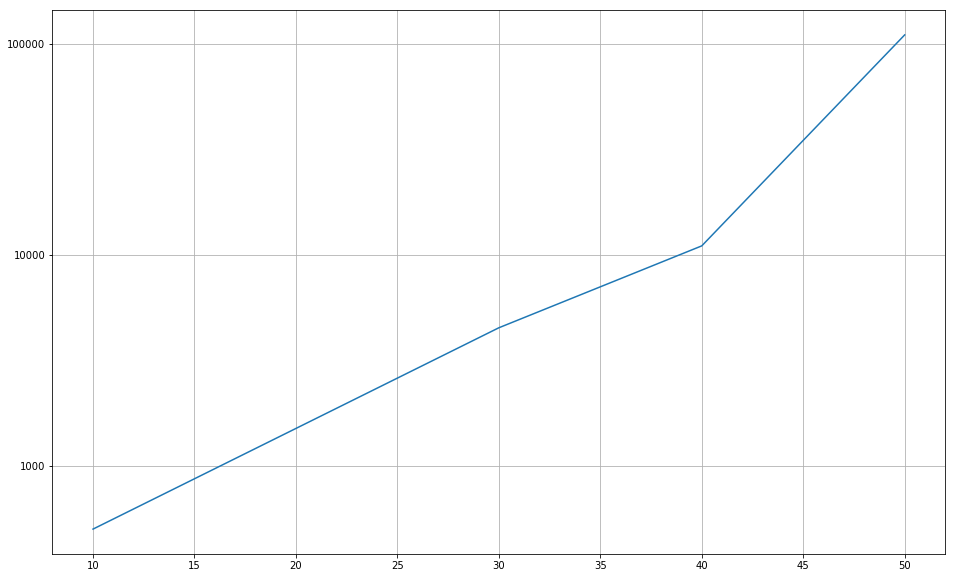

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

a = np.array([500, 1500, 4500, 11000, 110000])
b = np.array([10, 20, 30, 40, 50])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_yscale('symlog')

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

plt.plot(b, a)
plt.grid(True)

plt.show()

AR1
[-9, -8, -7, -6, -5, -4, -3, -2, 0, 2]
AR2
[-9, -8, -7, -6, -5, -4, -3, -2, 0, 2]
AR3
[-9, -8, -7, -6, -5, -4, -3, -2, 0, 2]
AR4
[-9, -8, -7, -6, -5, -4, -3, -2, 0, 2]
AR5
[-9, -8, -7, -6, -5, -4, -3, -2, 0, 2]


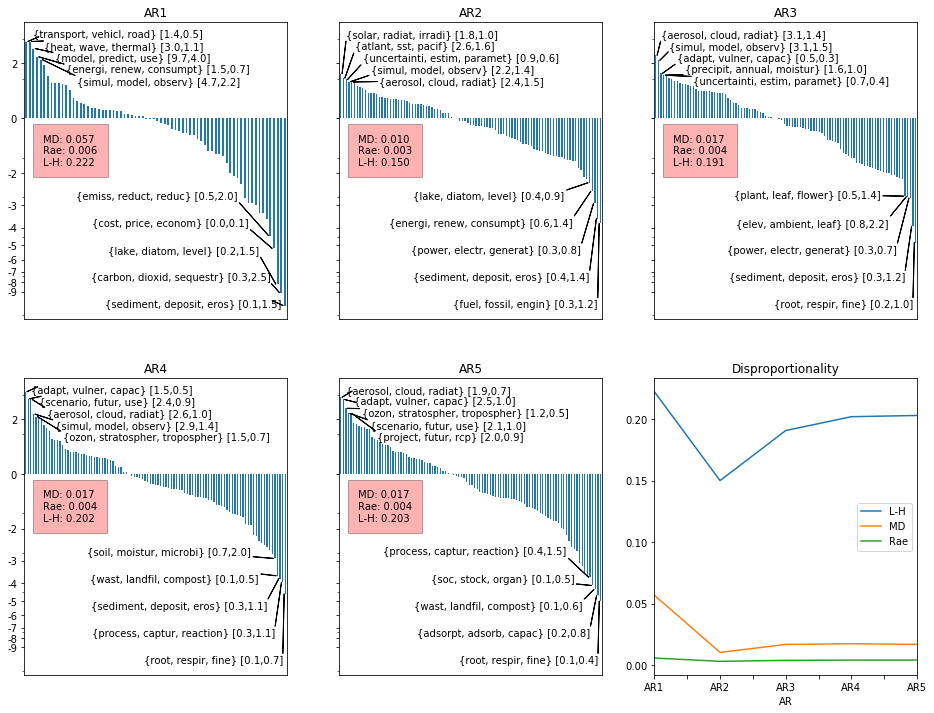

,L-H,MD,Rae
AR,,,
AR1,0.222256,0.056783,0.005699
AR2,0.150022,0.010283,0.003031
AR3,0.190731,0.016758,0.003815
AR4,0.201980,0.017338,0.004040
AR5,0.202982,0.016772,0.004060


In [143]:
plt.rcParams["figure.figsize"] = [16,12]

stat = RunStats.objects.get(pk=run_id)

fig = plt.figure()


disp = pd.DataFrame(columns=['AR','MD','Rae','L-H'])
#fig, axs = plt.subplots(2,3,sharey=True)

for i, tp in enumerate(stat.periods.filter(n__lt=6)):
    if i == 0:
        ax = fig.add_subplot(2,3,i+1)
        ax1 = ax
    else:
        ax = fig.add_subplot(2,3,i+1,sharey=ax1)
    print(tp)
    tdts = TimeDTopic.objects.filter(dtopic__run_id=run_id,period=tp)
    
    df = pd.DataFrame.from_dict(
        list(tdts.values(
            'dtopic__title',
            'score',
            'share',
            'ipcc_score',
            'ipcc_share',
            #'ipcc_time_score'
        ))
    )
    
    df = df.rename(columns={'dtopic__title':'title'})
    
    df, df_disp  = calculate_deviations(df)
    df_disp['AR'] = tp.title   
    disp = disp.append(pd.DataFrame.from_dict([df_disp]))

    plot_representation(df, ax, 2.3,1)
    
    ax.set_title(tp.title)
    
    if tp.title=="AR5":
        ax = fig.add_subplot(2,3,6)
        
        disp = disp.set_index('AR')
        
        disp.plot(ax=ax)
        
        ax.set_title("Disproportionality")
    
    
    
    #plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_{}.png'.format(run_id,tp.title),bbox_inches='tight')
    #plt.show()

plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_ARS.png'.format(run_id),bbox_inches='tight')
plt.show()

disp.head()